# Train GRWG Model
This notebook will develop and train a neural network to predict the percent change in the GRWG price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'GRWG'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,1.421789,9.289893,27.211683,0.798439,-26.150860,-1.090387,14.892066,-16.523873,19.198828,0.380681,...,2.0,0.0,10.0,6.0,0.000000,0.600000,0.400000,0.000000,0.625000,0.375000
2021-03-02,-1.109781,9.057138,26.827163,0.427229,-44.367143,-1.172123,10.353380,-17.194793,14.331047,0.237180,...,3.0,3.0,3.0,6.0,0.200000,0.200000,0.600000,0.250000,0.250000,0.500000
2021-03-03,-2.180267,8.754978,26.343850,0.029216,-95.748470,-1.100065,-34.473240,-22.892266,-20.779153,0.237180,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-04,-0.983543,8.530923,25.318105,-0.308213,-156.216698,-1.001321,-20.701104,-22.413170,-37.450198,0.237180,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-05,0.305016,9.164546,26.367481,0.088551,-126.150444,-1.011162,-17.987850,-24.711287,-19.653081,0.237180,...,0.0,0.0,3.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2021-03-08,-0.209284,8.919622,25.947432,-0.162592,-131.309396,-1.146862,16.969990,-27.219226,-4.933687,0.068521,...,0.0,0.0,3.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2021-03-09,2.656014,9.183187,26.524315,-0.165621,-29.297954,-0.865656,15.521847,-20.992482,21.197960,0.068521,...,0.0,0.0,17.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2021-03-10,0.278408,9.184515,26.948779,-0.178298,-17.948600,-0.655351,18.910277,-13.102848,30.746532,0.112304,...,0.0,0.0,4.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2021-03-11,-0.333660,9.389331,27.349322,-0.031991,12.705695,-0.632997,8.471755,-13.469414,10.140412,0.294004,...,1.0,0.0,3.0,-6.0,0.000000,0.500000,0.500000,0.000000,0.333333,-0.666667


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 23s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 2s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|drop: 0.

Training complete in 0m 4s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 7s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 7s
Iteration: 90 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 8s
Iteration: 91 |periods: 1|hidden: 10|layer

Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 7s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 4s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 6s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 12s
Iteration: 169 |periods: 1|hidden: 50|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 3s
Iteration: 170 |periods: 5|hidden: 50|layers: 3|drop: 0.25|lr: 0

Training complete in 0m 10s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 8s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 10s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 3s
Iteration: 248 |periods: 5|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 249 |periods: 10|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 250 |periods: 20|hidden: 

Training complete in 0m 3s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 4s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 7s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 9s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 13s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 327 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 328 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 5s
Iteration: 329 |periods: 40|hidden: 10

Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 7s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 2s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 3s
Iteration: 406 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 4s
Iteration: 407 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 408 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5

Training complete in 0m 3s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 6s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 3s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 4s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 485 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 6s
Iteration: 486 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 487 

Training complete in 0m 4s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 5s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 563 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 564 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 565 |periods: 1|hidden: 

Training complete in 0m 6s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 4s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 642 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 643 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 3s
Iteration: 644 |periods: 5|hidden: 10

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

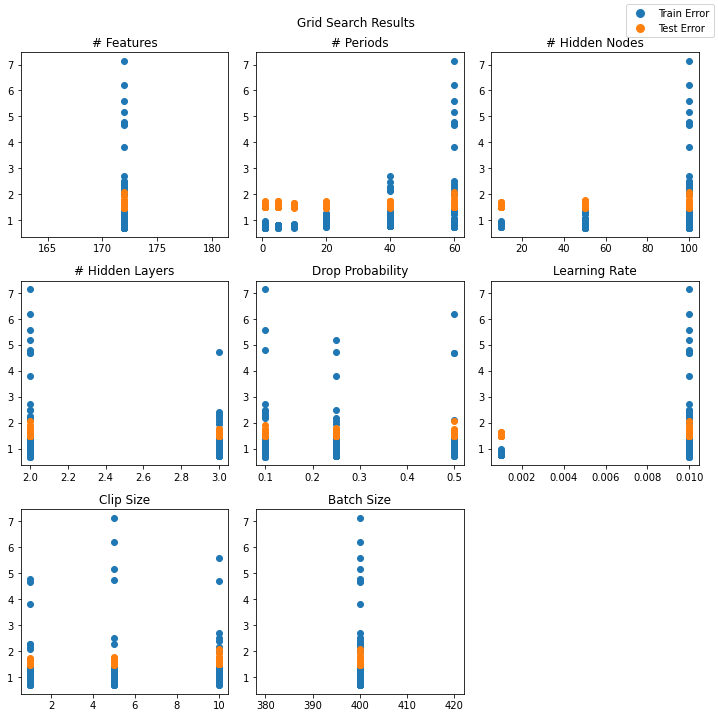

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
68,0.772101,1.472068,172.0,10.0,100.0,3.0,0.25,0.001,1.0,400.0
231,0.755689,1.472370,172.0,20.0,100.0,2.0,0.10,0.001,5.0,400.0
226,0.778803,1.476567,172.0,40.0,50.0,2.0,0.10,0.001,5.0,400.0
153,0.766760,1.481713,172.0,20.0,50.0,2.0,0.25,0.010,1.0,400.0
285,0.778122,1.487151,172.0,20.0,100.0,3.0,0.25,0.001,5.0,400.0
...,...,...,...,...,...,...,...,...,...,...
600,0.759909,1.756929,172.0,1.0,50.0,3.0,0.25,0.010,10.0,400.0
551,1.288073,1.763584,172.0,60.0,50.0,2.0,0.10,0.010,10.0,400.0
377,5.172989,1.790098,172.0,60.0,100.0,2.0,0.25,0.010,5.0,400.0
557,5.579589,1.924432,172.0,60.0,100.0,2.0,0.10,0.010,10.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 100, num_layers=3, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1000, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [19]:
batch_size = [20,40,80,240,480,960]
epochs = [500]

In [20]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 6 different configurations.
Iteration: 1 |epochs: 500|periods: 10|hidden: 100|layers: 3|drop: 0.25|lr: 0.001|clip: 1
Training complete in 61m 53s
Iteration: 2 |epochs: 500|periods: 10|hidden: 100|layers: 3|drop: 0.25|lr: 0.001|clip: 1
Training complete in 30m 33s
Iteration: 3 |epochs: 500|periods: 10|hidden: 100|layers: 3|drop: 0.25|lr: 0.001|clip: 1
Training complete in 15m 19s
Iteration: 4 |epochs: 500|periods: 10|hidden: 100|layers: 3|drop: 0.25|lr: 0.001|clip: 1
Training complete in 6m 19s
Iteration: 5 |epochs: 500|periods: 10|hidden: 100|layers: 3|drop: 0.25|lr: 0.001|clip: 1
Training complete in 3m 34s
Iteration: 6 |epochs: 500|periods: 10|hidden: 100|layers: 3|drop: 0.25|lr: 0.001|clip: 1
Training complete in 2m 19s
Grid search complete in 119m 59s


In [21]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

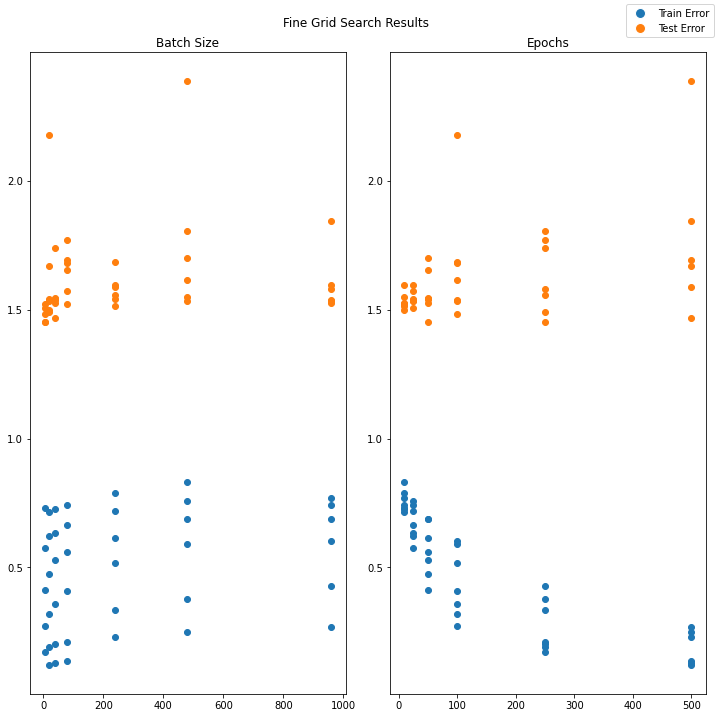

In [22]:
dh.visualizeFineGridSearch(fine_grid_result)

In [23]:
resultdf = dh.resultDFFine(fine_grid_result)

In [24]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
28,0.172515,1.450591,172.0,10.0,100.0,3.0,0.25,0.001,1.0,4.0,250.0
14,0.414001,1.450887,172.0,10.0,100.0,3.0,0.25,0.001,1.0,4.0,50.0
36,0.130837,1.467338,172.0,10.0,100.0,3.0,0.25,0.001,1.0,40.0,500.0
21,0.272822,1.483680,172.0,10.0,100.0,3.0,0.25,0.001,1.0,4.0,100.0
29,0.192663,1.491558,172.0,10.0,100.0,3.0,0.25,0.001,1.0,20.0,250.0
1,0.715528,1.497242,172.0,10.0,100.0,3.0,0.25,0.001,1.0,20.0,10.0
7,0.577109,1.506016,172.0,10.0,100.0,3.0,0.25,0.001,1.0,4.0,25.0
4,0.790369,1.514270,172.0,10.0,100.0,3.0,0.25,0.001,1.0,240.0,10.0
3,0.740730,1.520463,172.0,10.0,100.0,3.0,0.25,0.001,1.0,80.0,10.0
0,0.729480,1.522985,172.0,10.0,100.0,3.0,0.25,0.001,1.0,4.0,10.0


## Evaluate Final Model

In [25]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 100, num_layers=3, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1000, out_features=1, bias=True)
)

Training RMSE: 0.5279642850794767
Test RMSE: 3.720987203109243
Training MAE: 0.12678747859034667
Test MAE: 3.20048751866135
Training - Above Error: $0.13 (44.33%) Below Error: $-0.12 (55.67%)
Test - Above Error: $3.23 (32.43%) Below Error: $-3.18 (67.57%)


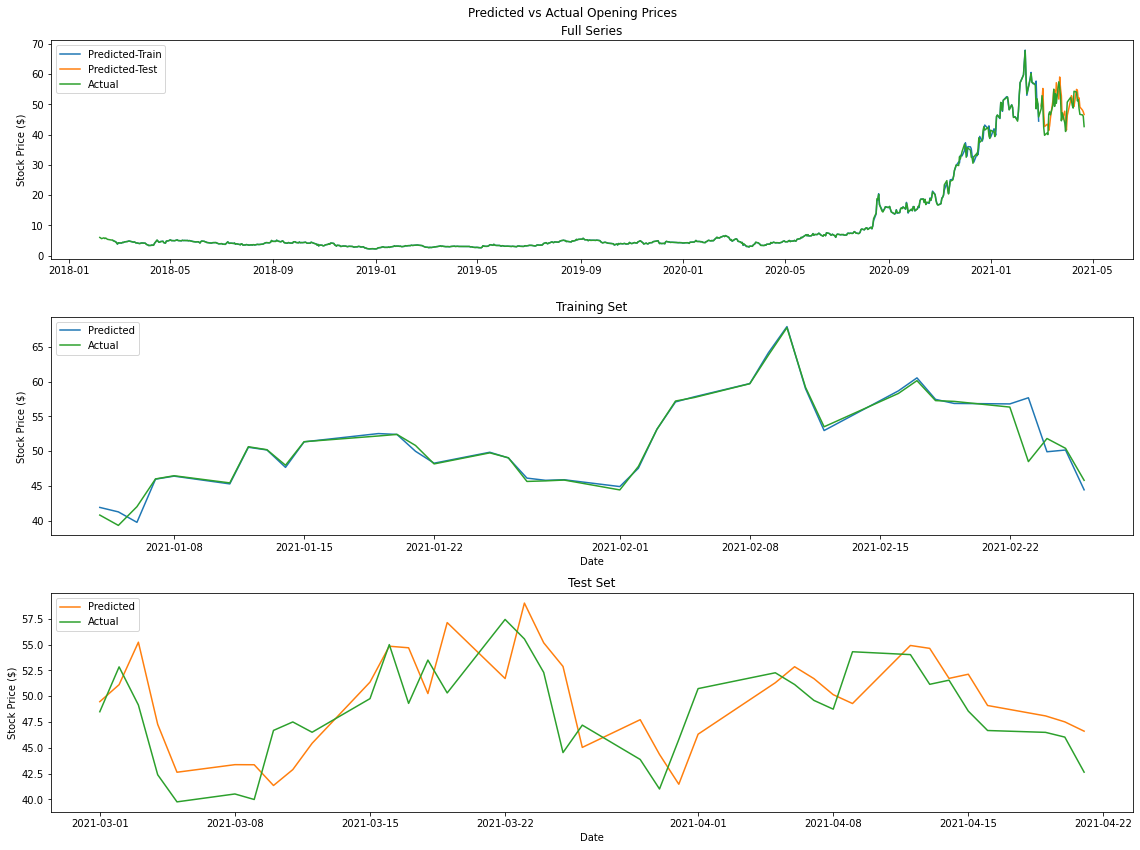

In [26]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [27]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,48.549999,0.011213,Test,52.127044
2021-04-16,46.668999,0.030358,Test,49.094415
2021-04-19,46.490002,0.021881,Test,48.085779
2021-04-20,46.029999,0.012489,Test,47.507251
2021-04-21,42.630001,0.019559,Test,46.604879


In [28]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [29]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)